In [1]:
from glob import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

sns.set_style('whitegrid')

/tmp/ipykernel_10681/3899321594.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
all_df = []
for f in glob('results/*'):
    df = pd.read_csv(f)
    model =  f.split('/')[-1].split('__')[0]

    model = model.replace('ComponentwiseGradientBoostingSurvivalAnalysis', 'CompGradBoost')
    model = model.replace('GradientBoostingSurvivalAnalysis', 'GradBoost')
    model = model.replace('RandomSurvivalForest', 'RandomForest')
    model = model.replace('ExtraSurvivalTrees', 'ExtraTrees')
        
    df['model'] = model
    df['dataset'] = f.split('/')[-1].split('__')[-1].split('.csv')[0]
    all_df.append(df)
df_scores = pd.concat(all_df)
df_scores = df_scores[~df_scores['model'].str.contains('BaggedICARE')]

In [3]:
datasets_to_drop = ['SurvSet_Framingham', 'SurvSet_grace', 'SurvSet_pharmacoSmoking', 'SurvSet_zinc']
df_scores = df_scores[~df_scores['dataset'].isin(datasets_to_drop)]

In [4]:
datasets = df_scores['dataset'].unique()

df_datasets = []
for dataset in tqdm(datasets):
    with open('datasets/'+dataset+'.pickle', 'rb') as handle:
        data = pickle.load(handle)
    X, y = data['X'], data['y']

    isna_mean = X.isna().mean()
    
    df_datasets.append({
        'name': dataset,
        'n_samples': X.shape[0],
        'n_features': X.shape[1],
        'n_features/n_samples': X.shape[1] / X.shape[0],
        'n_happened': y['event'].sum(),
        'nan_mean': isna_mean.mean(),
        'nan_max': isna_mean.max(),
        
    })
df_datasets = pd.DataFrame(df_datasets)
df_datasets['datatype'] = 'SurvSet'
df_datasets.loc[df_datasets['name'].str.contains('TCGA'), 'datatype'] = 'TCGA'

df_datasets['n_censored'] = df_datasets['n_samples'] - df_datasets['n_happened']
df_datasets['censoring'] = df_datasets['n_censored'] / df_datasets['n_samples']

df_scores_prepro = df_scores[~df_scores['model'].str.contains('_noprepro')]

max_scores_dt = df_scores_prepro.groupby(['dataset', 'model']).mean()['tAUC'].reset_index().groupby('dataset')['tAUC'].max()
median_scores_dt = df_scores_prepro.groupby(['dataset', 'model']).mean()['tAUC'].reset_index().groupby('dataset')['tAUC'].median()
min_scores_dt = df_scores_prepro.groupby(['dataset', 'model']).mean()['tAUC'].reset_index().groupby('dataset')['tAUC'].min()
df_datasets['max_scores'] = max_scores_dt.loc[df_datasets.name].values
df_datasets['median_scores'] = median_scores_dt.loc[df_datasets.name].values
df_datasets['min_scores'] = min_scores_dt.loc[df_datasets.name].values
df_datasets.set_index('name', inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 71/71 [00:23<00:00,  3.08it/s]


# Datasets stats

In [5]:
df_datasets[df_datasets['datatype']=='SurvSet'].shape

(51, 12)

In [6]:
df_datasets[df_datasets['datatype']=='TCGA'].shape

(20, 12)

In [7]:
df_datasets[df_datasets['datatype']=='TCGA']['n_features'].min()

19324

In [8]:
df_datasets[df_datasets['datatype']=='TCGA']['n_features'].max()

19547

In [9]:
df_datasets[df_datasets['datatype']=='SurvSet']['n_features'].min()

4

In [10]:
df_datasets[df_datasets['datatype']=='SurvSet']['n_features'].max()

8664

In [11]:
', '.join([x.replace('SurvSet_', '') for x in df_datasets[df_datasets['datatype']=='SurvSet'].index])

'DBCD, d.oropha.rec, chop, prostate, flchain, whas500, pbc, cgd, cost, Dialysis, Z243, actg, diabetes, rott2, stagec, follic, smarto, Pbc3, nki70, dataDIVAT1, cancer, uis, gse3143, e1684, GBSG2, MCLcleaned, hepatoCellular, nwtco, vlbw, colon, AML_Bull, mgus, DLBCL, Melanoma, acath, Aids2, dataOvarian1, rdata, dataDIVAT2, burn, LeukSurv, retinopathy, dataDIVAT3, prostateSurvival, phpl04K8a, TRACE, ova, support2, wpbc, veteran, FRTCS'

In [12]:
', '.join([x.replace('TCGA_', '') for x in df_datasets[df_datasets['datatype']=='TCGA'].index])

'SARC, STAD, KIRP, LUAD, OV, BRCA, CESC, KIRC, COAD, LAML, UCEC, LGG, LUSC, PAAD, GBM, MESO, LIHC, BLCA, HNSC, ESCA'

In [13]:
[x.replace('TCGA_', '') for x in df_datasets[df_datasets['datatype']=='TCGA'].index]

['SARC',
 'STAD',
 'KIRP',
 'LUAD',
 'OV',
 'BRCA',
 'CESC',
 'KIRC',
 'COAD',
 'LAML',
 'UCEC',
 'LGG',
 'LUSC',
 'PAAD',
 'GBM',
 'MESO',
 'LIHC',
 'BLCA',
 'HNSC',
 'ESCA']

In [14]:
prec = 4
for dataset in ['SurvSet', 'TCGA']:
    print(dataset)
    r = []
    dfdt = df_datasets[df_datasets['datatype']==dataset]
    for f in ['n_samples', 'n_features', 'n_features/n_samples', 'censoring', 'max_scores', 'nan_mean']:
        r.append({
            'feature': f,
            'minimum': dfdt[f].min().round(prec),
            'median': dfdt[f].median().round(prec),
            'mean': dfdt[f].mean().round(prec),
            'std': dfdt[f].std().round(prec),
            'maximum': dfdt[f].max().round(prec),
         })
    display(pd.DataFrame(r).T)
        
            

SurvSet


,0,1,2,3,4,5
feature,n_samples,n_features,n_features/n_samples,censoring,max_scores,nan_mean
minimum,92.0,4.0,0.0006,0.0,0.5697,0.0
median,461.0,23.0,0.0391,0.5734,0.7308,0.0
mean,1664.7451,645.4706,3.4351,0.537,0.7343,0.0108
std,2773.8194,1935.5843,11.5695,0.2491,0.0908,0.0396
maximum,14294.0,8664.0,54.8354,0.9441,0.9734,0.2577


TCGA


,0,1,2,3,4,5
feature,n_samples,n_features,n_features/n_samples,censoring,max_scores,nan_mean
minimum,86.0,19324.0,17.8609,0.1512,0.5393,0.0
median,405.5,19497.0,48.143,0.6175,0.6723,0.0
mean,392.65,19480.3,69.6843,0.596,0.6851,0.0
std,221.6451,55.4485,49.3687,0.1985,0.0873,0.0
maximum,1093.0,19547.0,224.6977,0.8618,0.8795,0.0


In [16]:
df_datasets['n_samples/n_features'] = df_datasets['n_samples'] / df_datasets['n_features']
df_datasets['n_features/n_samples'] = df_datasets['n_features'] / df_datasets['n_samples']

In [17]:
palette = ['#b3dee2','#ea9ab2']

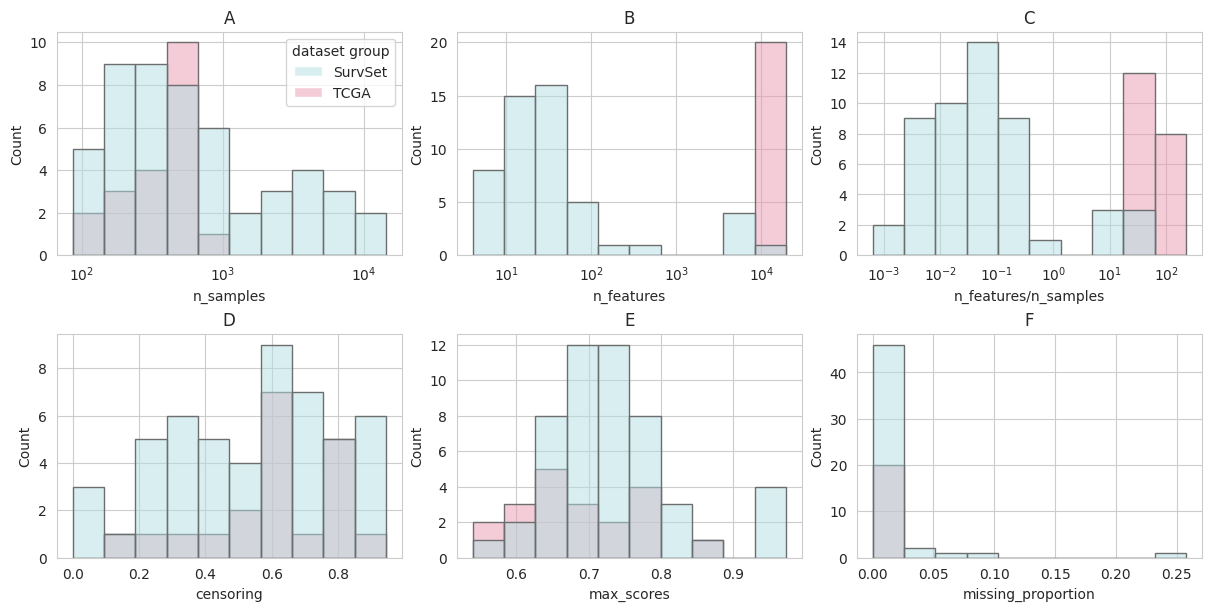

In [20]:
use_log = ['n_samples', 'n_features', 'n_features/n_samples']
binwidth = {
    'n_samples': 0.25,
    'n_features': 1,
    'censoring': 0.1,
    'max_scores': 0.04,
    'n_features/n_samples': 0.5,
}

df_datasets['missing_proportion'] = df_datasets['nan_mean']


plt.figure(figsize=(12,6), layout='constrained')
plotid = 0

titles = ['A', 'B', 'C', 'D', 'E', 'F']
titleid = 0
for c in ['n_samples', 'n_features', 'n_features/n_samples', 'censoring', 'max_scores', 'missing_proportion']:
    plotid += 1
    plt.subplot(2,3,plotid)
    if c in use_log:
        log = True
    else:
        log = False

    if plotid == 1:
        legend = True
    else:
        legend = False
    # ax = sns.histplot(df_datasets[df_datasets['datatype']=='SurvSet'], x=c, stat='proportion',
    #                   alpha=0.5, label='SurvSet', log_scale=log, binwidth=binwidth[c], color=palette[0])
    # # if c != 'n_features':
    # ax = sns.histplot(df_datasets[df_datasets['datatype']=='TCGA'], x=c, stat='proportion',
    #                   alpha=0.5, label='TCGA', log_scale=log, binwidth=binwidth[c], color=palette[1], line_kws={'color': 'red'})

    df_datasets_c = df_datasets.copy()
    df_datasets_c = df_datasets_c.rename(columns={'datatype': 'dataset group'})
    
    ax = sns.histplot(df_datasets_c, x=c, hue='dataset group', stat='count', bins=10,
                      alpha=0.5, log_scale=log, palette=palette, legend=legend)

    import matplotlib.patches
    children = ax.get_children()
    for child in children:
        if isinstance(child, matplotlib.patches.Rectangle):
            # match edgecolors to facecolors
            clr = child.get_facecolor()
            child.set_edgecolor('#6c6e6e')
    

    # if plotid == 5:
    #     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='dataset group')
    # if plotid == 1:
    #     plt.legend(title='dataset group')
    plt.title(titles[titleid])
    titleid += 1
plt.show()    

In [21]:
df_datasets['nan_mean'][df_datasets['nan_mean'] != 0].shape[0]

15

TCGA 0
Survset 15 with a least one missing
Survset 9 less than one percent of missing data
Survset 11 less than 5 percent of missing data
Survset 1 26%

In [22]:
df_datasets['nan_mean'][(df_datasets['nan_mean'] != 0) & (df_datasets['nan_mean'] > 0.05)]

name
SurvSet_hepatoCellular    0.257709
SurvSet_mgus              0.074689
SurvSet_acath             0.088898
SurvSet_support2          0.050184
Name: nan_mean, dtype: float64

# Models scores

In [23]:
sorted_models = [
    'Coxnet',
    
    'ICARE',
    
    'DecisionTree',
    'ExtraTrees',
    'RandomForest',
    'GradBoost',
    'CompGradBoost',
    
    'LinearSVM',
    'KernelSVM',
    
]

In [24]:
mean_score_by_model = df_scores.groupby(['dataset', 'model'])[['tAUC', 'tAUC_train']].agg([ np.nanmean]).reset_index()
mean_score_by_model = mean_score_by_model.T.reset_index().drop(columns='level_1').T.reset_index(drop=True)
mean_score_by_model.columns = mean_score_by_model.iloc[0]
mean_score_by_model = mean_score_by_model.drop(0).reset_index()
mean_score_by_model = mean_score_by_model.drop(columns='index')
mean_score_by_model['datatype'] = 'SurvSet'
mean_score_by_model.loc[mean_score_by_model['dataset'].str.contains('TCGA'), 'datatype'] = 'TCGA'
mean_score_by_model['core_model'] = mean_score_by_model['model'].str.split('_', expand=True)[0]
mean_score_by_model['prepro'] = True
mean_score_by_model.loc[mean_score_by_model['model'].str.contains('_noprepro'), 'prepro'] = False
mean_score_by_model

/tmp/ipykernel_10681/386938497.py:1: FutureWarning: The provided callable <function nanmean at 0x7f4a08a6a980> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mean_score_by_model = df_scores.groupby(['dataset', 'model'])[['tAUC', 'tAUC_train']].agg([ np.nanmean]).reset_index()
/tmp/ipykernel_10681/386938497.py:1: FutureWarning: The provided callable <function nanmean at 0x7f4a08a6a980> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mean_score_by_model = df_scores.groupby(['dataset', 'model'])[['tAUC', 'tAUC_train']].agg([ np.nanmean]).reset_index()


,dataset,model,tAUC,tAUC_train,datatype,core_model,prepro
0,SurvSet_AML_Bull,CompGradBoost,0.619643,0.797536,SurvSet,CompGradBoost,True
1,SurvSet_AML_Bull,CompGradBoost_noprepro,0.661572,0.893129,SurvSet,CompGradBoost,False
2,SurvSet_AML_Bull,Coxnet,0.674421,0.834967,SurvSet,Coxnet,True
3,SurvSet_AML_Bull,Coxnet_noprepro,0.586829,1.0,SurvSet,Coxnet,False
4,SurvSet_AML_Bull,DecisionTree,0.573918,0.700151,SurvSet,DecisionTree,True
...,...,...,...,...,...,...,...
1273,TCGA_UCEC,KernelSVM_noprepro,0.676392,0.999999,TCGA,KernelSVM,False
1274,TCGA_UCEC,LinearSVM,0.646312,0.901122,TCGA,LinearSVM,True
1275,TCGA_UCEC,LinearSVM_noprepro,0.647878,1.0,TCGA,LinearSVM,False
1276,TCGA_UCEC,RandomForest,0.636772,0.848253,TCGA,RandomForest,True


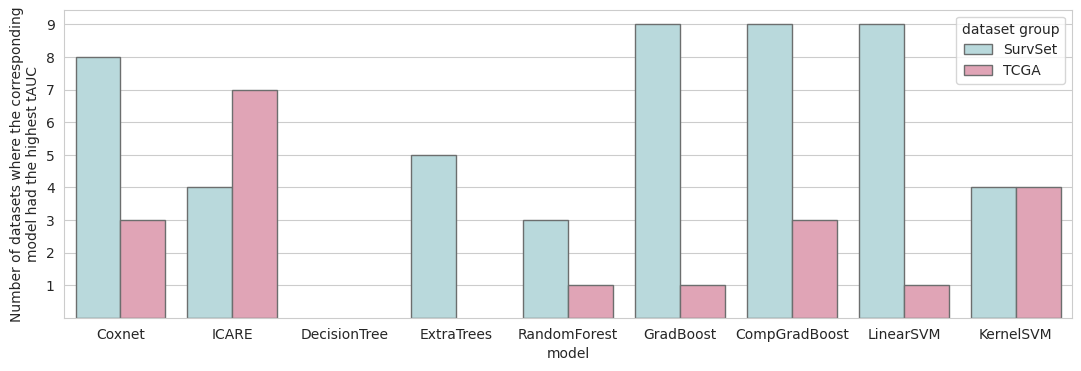

In [25]:
best_surv = []
best_tcga = []
for dataset in mean_score_by_model['dataset'].unique():
    mdt = mean_score_by_model[mean_score_by_model['dataset']==dataset]
    mdt = mdt[mdt['prepro']]
    if mdt['tAUC'].isna().mean() > -1:
        if mdt['datatype'].values[0] == 'TCGA':
            best_tcga.append(mdt[mdt['tAUC']==mdt['tAUC'].max()]['core_model'].values[0])
        else:
            best_surv.append(mdt[mdt['tAUC']==mdt['tAUC'].max()]['core_model'].values[0])

n_times_best_survset = pd.DataFrame()
n_times_best_survset['model'], n_times_best_survset['n'] = np.unique(best_surv, return_counts=True)
n_times_best_survset['datatype'] = 'SurvSet'

n_times_best_tcga = pd.DataFrame()
n_times_best_tcga['model'], n_times_best_tcga['n'] = np.unique(best_tcga, return_counts=True)
n_times_best_tcga['datatype'] = 'TCGA'

best = pd.concat([n_times_best_survset, n_times_best_tcga])
plt.figure(figsize=(13,4))
ax = sns.barplot(best, x='model', y='n', hue='datatype', order=sorted_models, palette=palette)

import matplotlib.patches
children = ax.get_children()
for child in children:
    if isinstance(child, matplotlib.patches.Rectangle):
        # match edgecolors to facecolors
        clr = child.get_facecolor()
        child.set_edgecolor('#6c6e6e')


plt.legend(loc='upper right', title='dataset group') #, bbox_to_anchor=(1, 0.6))
plt.ylabel('Number of datasets where the corresponding\nmodel had the highest tAUC')
plt.yticks(np.arange(best['n'].min(), best['n'].max()+1, 1.0))
plt.show()

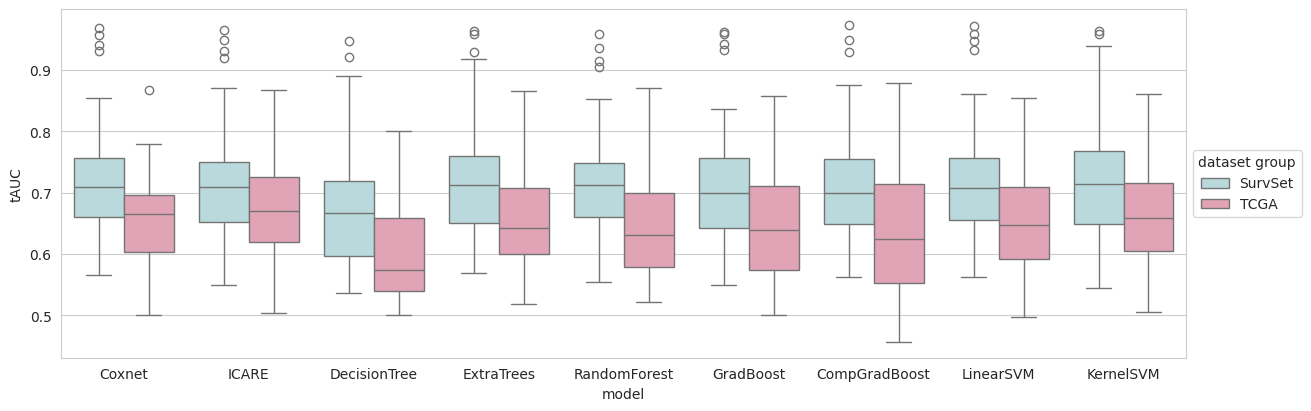

In [26]:
plt.figure(figsize=(13,4), layout='constrained')
sns.boxplot(mean_score_by_model,
                x='model', y='tAUC', hue='datatype',
                order=sorted_models, palette=palette)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='dataset group')

In [27]:
mean_score_by_model_prepro = mean_score_by_model[mean_score_by_model['prepro']].copy()
mean_score_by_model_noprepro = mean_score_by_model[~mean_score_by_model['prepro']].copy()

mean_score_by_model_prepro['best_model_score'] = df_datasets.loc[mean_score_by_model_prepro['dataset'], 'max_scores'].values.astype('float64')
mean_score_by_model_prepro['best_model_score - score'] = (mean_score_by_model_prepro['best_model_score'] - mean_score_by_model_prepro['tAUC'] ).astype('float64')

In [28]:
mean_score_by_model_prepro['isbest'] = mean_score_by_model_prepro['best_model_score - score']==0
mean_score_by_model_prepro.groupby('model')['isbest'].sum()

model
CompGradBoost    12
Coxnet           11
DecisionTree      0
ExtraTrees        5
GradBoost        10
ICARE            11
KernelSVM         8
LinearSVM        10
RandomForest      4
Name: isbest, dtype: int64

In [29]:
mean_score_by_model['best_model_score'] = df_datasets.loc[mean_score_by_model['dataset'], 'max_scores'].values.astype('float64')
mean_score_by_model['best_model_score - score'] = (mean_score_by_model['best_model_score'] - mean_score_by_model['tAUC'] ).astype('float64')

Text(0, 0.5, 'Best model tAUC - model tAUC')

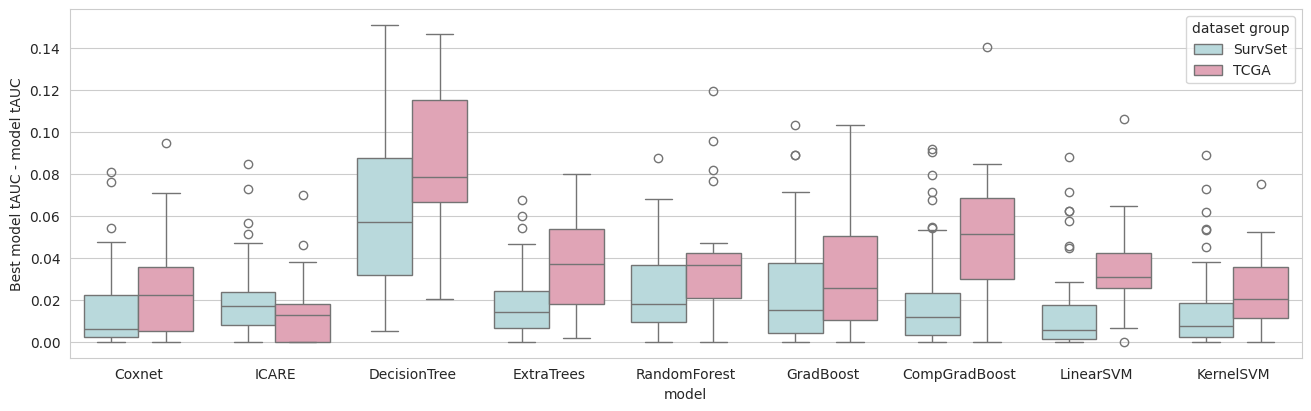

In [30]:
plt.figure(figsize=(13,4), layout='constrained')
sns.boxplot(mean_score_by_model,
            x='model', y='best_model_score - score', hue='datatype',
            order=sorted_models, palette=palette)
plt.legend(title='dataset group')
plt.ylabel('Best model tAUC - model tAUC')

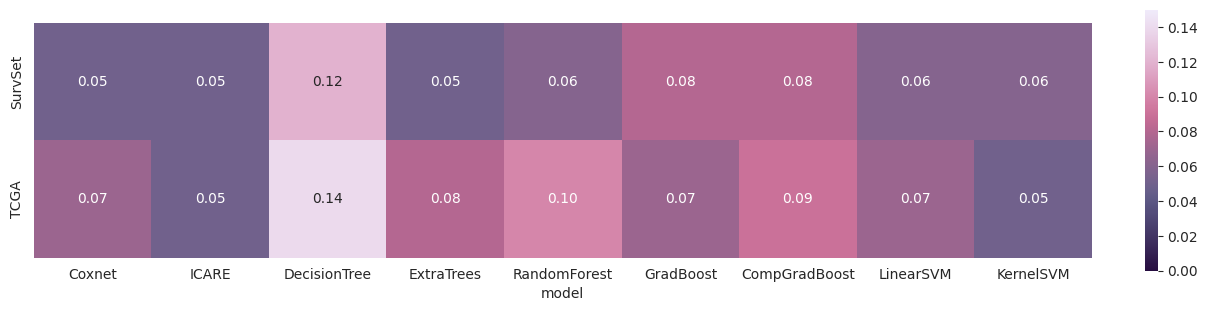

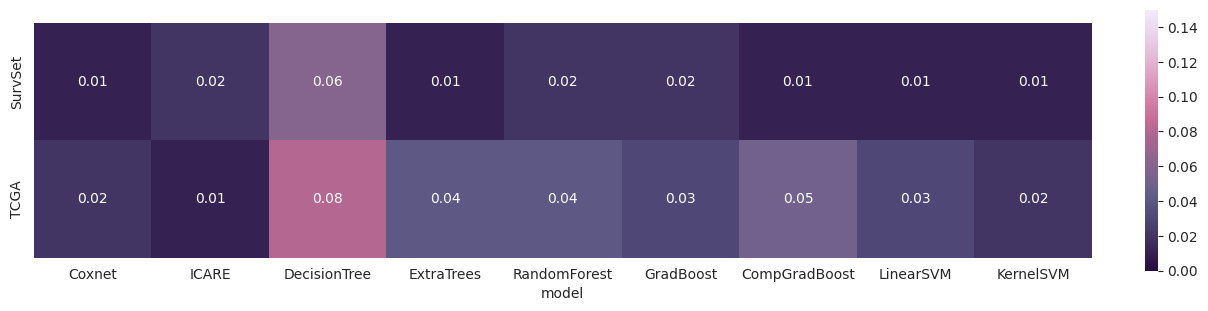

In [31]:
import cmocean
from cmcrameri import cm
cmap = cm.acton
# cmap = cmocean.cm.thermal

plt.figure(figsize=(12,3), layout='constrained')
cibest = mean_score_by_model.groupby(['datatype', 'model'])['best_model_score - score'].quantile(0.95).reset_index()
cibestres = pd.concat([
            cibest[cibest['datatype']=='SurvSet'].set_index('model')['best_model_score - score'],
            cibest[cibest['datatype']=='TCGA'].set_index('model')['best_model_score - score'],
          ], axis=1).round(2)
cibestres.columns = ['SurvSet', 'TCGA']
sns.heatmap(cibestres.loc[sorted_models].T.iloc[:2], annot=True, square=True, cmap=cmap, fmt='.2f', vmin=0, vmax=0.15)
plt.show()

plt.figure(figsize=(12,3), layout='constrained')
cibest = mean_score_by_model.groupby(['datatype', 'model'])['best_model_score - score'].quantile(0.5).reset_index()
cibestres = pd.concat([
            cibest[cibest['datatype']=='SurvSet'].set_index('model')['best_model_score - score'],
            cibest[cibest['datatype']=='TCGA'].set_index('model')['best_model_score - score'],
          ], axis=1).round(2)
cibestres.columns = ['SurvSet', 'TCGA']
sns.heatmap(cibestres.loc[sorted_models].T.iloc[:2], annot=True, square=True, cmap=cmap, fmt='.2f', vmin=0, vmax=0.15)
plt.show()

/tmp/ipykernel_10681/874888954.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_prepro.loc[:, 'prepro - noprepro'] = diff_prepro['tAUC'].values-diff_noprepro['tAUC'].values


Text(0.5, 0, 'model')

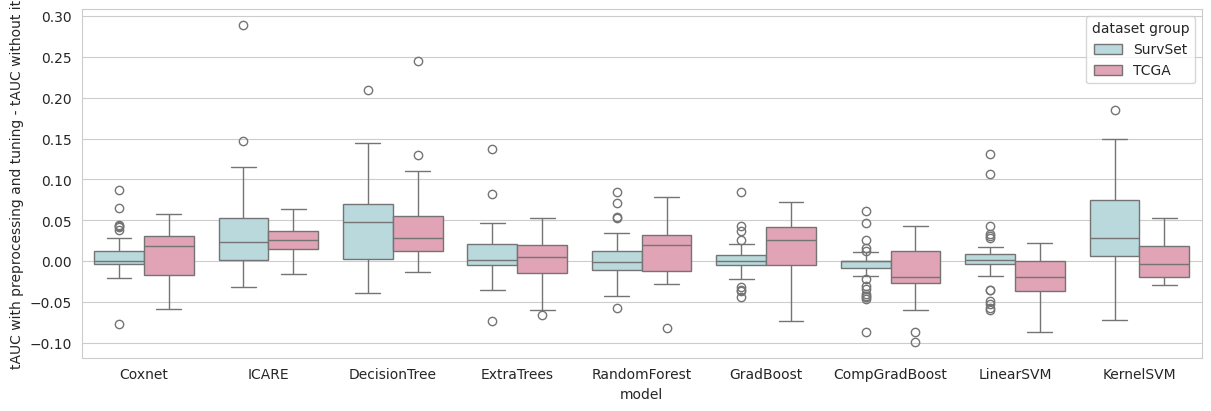

In [32]:
diff_prepro = mean_score_by_model[mean_score_by_model['prepro']==True]
diff_noprepro = mean_score_by_model[mean_score_by_model['prepro']==False]

assert np.array_equal(diff_prepro['dataset'].values, diff_noprepro['dataset'].values)
assert np.array_equal(diff_prepro['core_model'].values, diff_noprepro['core_model'].values)

diff_prepro.loc[:, 'prepro - noprepro'] = diff_prepro['tAUC'].values-diff_noprepro['tAUC'].values
plt.figure(figsize=(12,4), layout='constrained')
sns.boxplot(diff_prepro, x='core_model', y='prepro - noprepro', hue='datatype', order=sorted_models, palette=palette)
plt.legend(title='dataset group')
plt.ylabel('tAUC with preprocessing and tuning - tAUC without it')
plt.xlabel('model')

In [33]:
mean_score_by_model['core_model'] = mean_score_by_model['model'].str.split('_', expand=True)[0]
mean_score_by_model['prepro'] = True
mean_score_by_model.loc[mean_score_by_model['model'].str.contains('_noprepro'), 'prepro'] = False
mean_score_by_model['test-train'] = mean_score_by_model['tAUC'] - mean_score_by_model['tAUC_train']
mean_score_by_model['train-test'] = mean_score_by_model['tAUC_train'] - mean_score_by_model['tAUC'] 

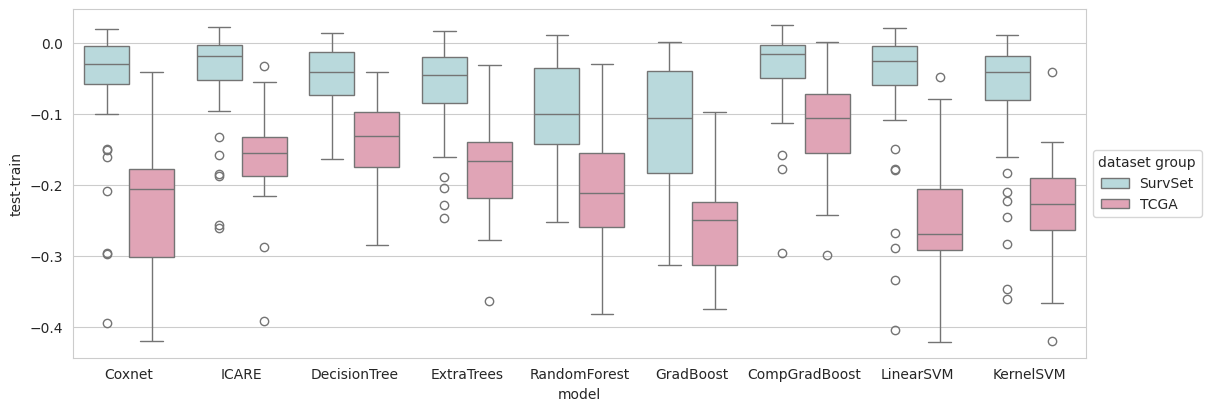

In [34]:
plt.figure(figsize=(12,4), layout='constrained')
sns.boxplot(mean_score_by_model,
            x='model', y='test-train',  order=sorted_models, hue='datatype', palette=palette)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='dataset group')

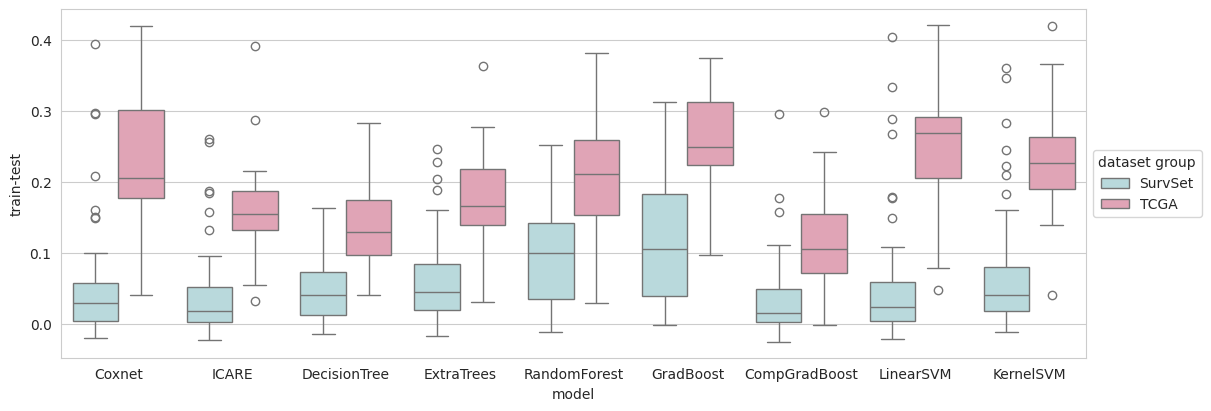

In [35]:
plt.figure(figsize=(12,4), layout='constrained')
sns.boxplot(mean_score_by_model,
            x='model', y='train-test',  order=sorted_models, hue='datatype', palette=palette)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='dataset group')

In [36]:
from scipy.stats import wilcoxon


all_res = []
for datatype in ['SurvSet', 'TCGA']:
    if datatype == 'all':
        dfdt = mean_score_by_model
    else:
        dfdt = mean_score_by_model[mean_score_by_model['datatype']==datatype]
    
    res = pd.DataFrame(data=1, index=sorted_models, columns=sorted_models, dtype='float')
    for m1 in sorted_models:
        for m2 in sorted_models:
            if m1 == m2:
                continue
            p = wilcoxon(dfdt[dfdt['model'] == m1]['test-train'].values,
                         dfdt[dfdt['model'] == m2]['test-train'].values,
                         nan_policy='omit',
                         alternative='greater'
                        ).pvalue
            res.loc[m1,m2] = p
    all_res.append(res)

In [37]:
c2 = '#f0eafa'
c1 = '#e2b2cf'

0.95


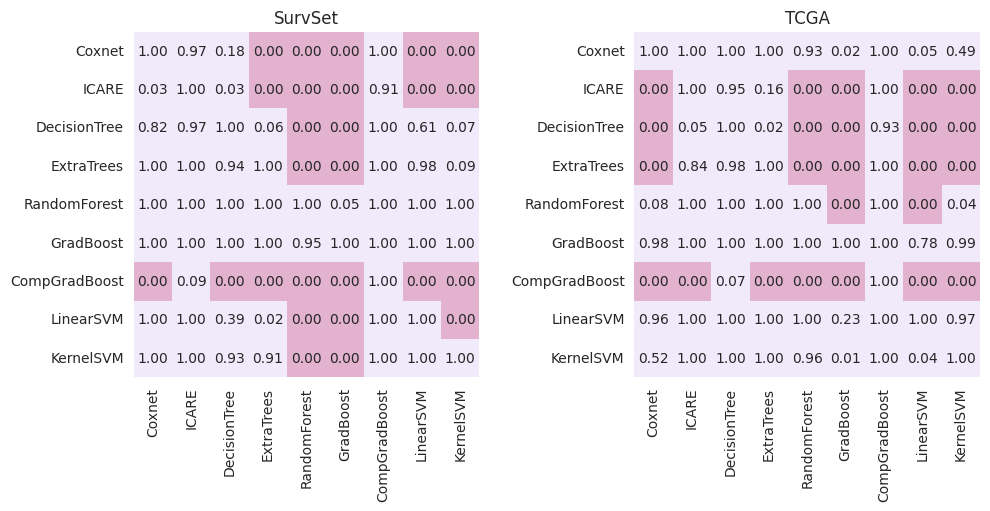

In [38]:
from scipy.stats import wilcoxon
from multipy.fdr import tst

q = 0.019

allpval = np.concatenate([all_res[0].values.ravel(), all_res[1].values.ravel()])
sel = tst(allpval, q=q)
print(sel.sum()*q)

sel_survset = sel[:len(all_res[0].values.ravel())]
sel_tcga    = sel[len(all_res[0].values.ravel()):]

sel_survset = sel_survset.reshape((9,9))
sel_tcga = sel_tcga.reshape((9,9))

plotid = 0
plt.figure(figsize=(10,5), layout='constrained')

plt.subplot(1,2,1)
sns.heatmap(all_res[0].round(2), annot=True, cbar=False, square=True, vmin=-1, vmax=0,  fmt='.2f', cmap=[c1, c2])
sns.heatmap(sel_survset, cbar=False, square=True, cmap=[c2, c1],  xticklabels=sorted_models, yticklabels=sorted_models)
plt.title('SurvSet')

plt.subplot(1,2,2)
sns.heatmap(all_res[1].round(2), annot=True, cbar=False, square=True, vmin=-1, vmax=0,  fmt='.2f', cmap=[c1, c2])
sns.heatmap(sel_tcga, cbar=False, square=True, cmap=[c2, c1],  xticklabels=sorted_models, yticklabels=sorted_models)
plt.title('TCGA')

plt.show()

In [39]:
mean_score_by_model['dataset_id'] = mean_score_by_model['dataset'].factorize()[0].astype('str')

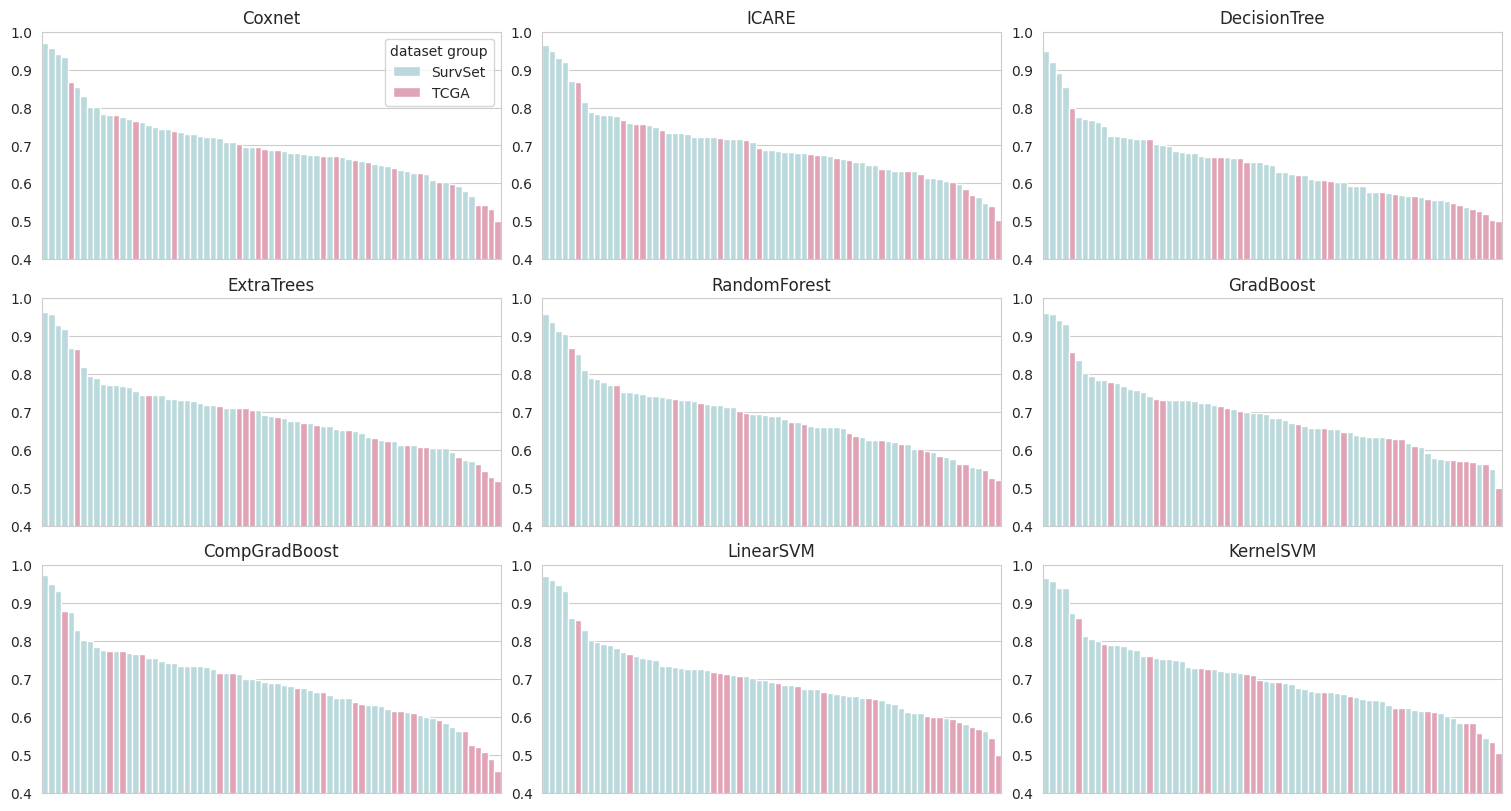

In [40]:
plt.figure(figsize=(15,8), layout='constrained')
for plotid in range(9):
    model = sorted_models[plotid]
    plt.subplot(3,3,plotid+1)
    if plotid == 0:
        legend = True
    else:
        legend = False
    
    sns.barplot(mean_score_by_model[mean_score_by_model['model']==model].sort_values('tAUC', ascending=False),
                y='tAUC', x='dataset_id', hue='datatype', palette=palette, width=1, legend=legend)
    plt.xticks([], [])
    if plotid == 0:
        plt.legend(title='dataset group')
    plt.xlabel('')
    plt.ylabel('')
    # plt.yticks([], [])
    plt.ylim(0.4,1)
    plt.title(model)

missing_proportion


/tmp/ipykernel_10681/3257187256.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_t.set_xticklabels(['     *'  if 'TCGA' in x else ' ' for x in order_dt])
/tmp/ipykernel_10681/3257187256.py:30: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.ticker.NullLocator'>
  ax_t.locator_params(nbins=len(order_dt))


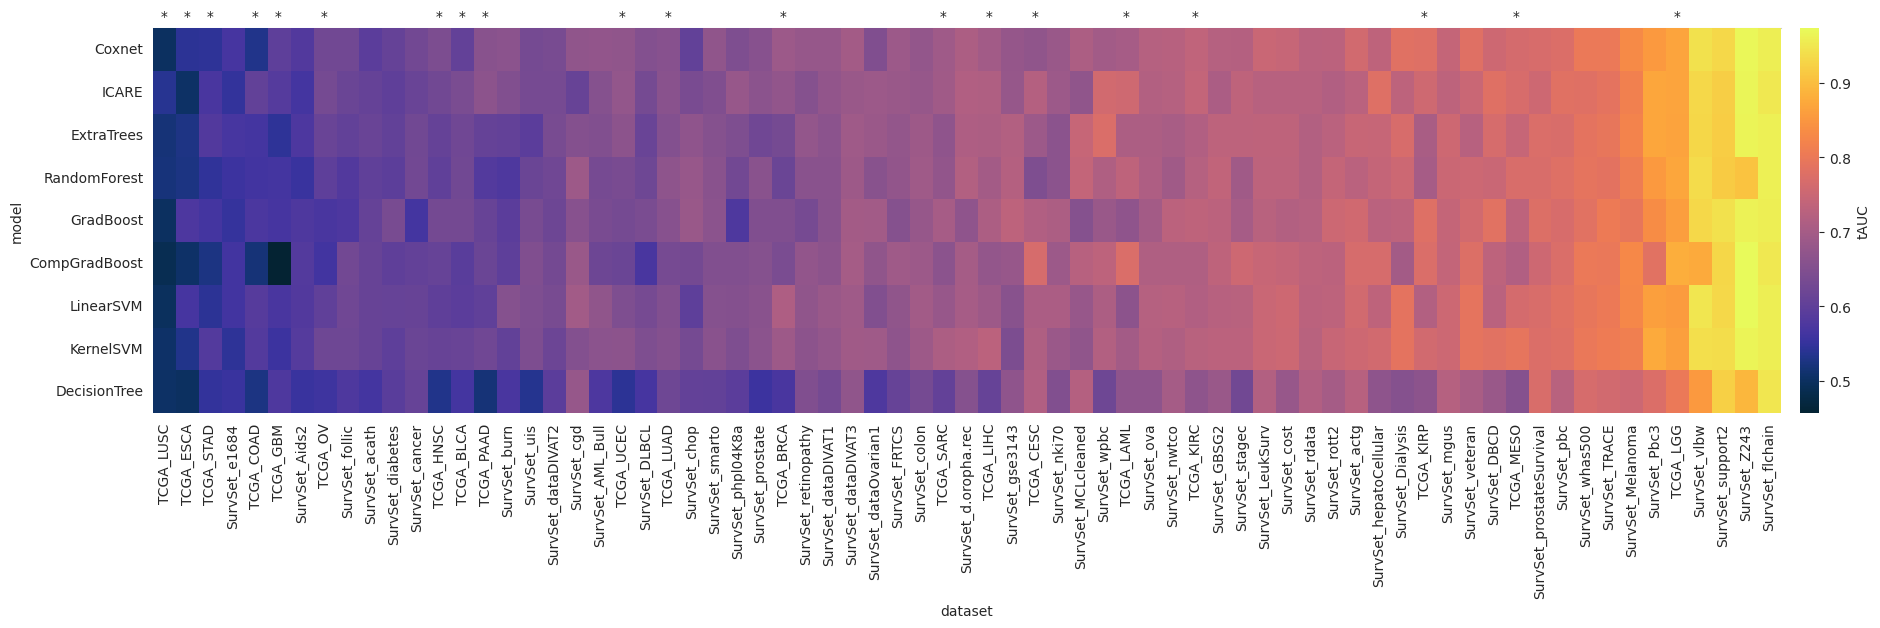

In [41]:
import cmocean

sorted_models_alt = [
    'Coxnet',
    
    'ICARE',
    
    
    'ExtraTrees',
    'RandomForest',
    'GradBoost',
    'CompGradBoost',
    
    'LinearSVM',
    'KernelSVM',

    'DecisionTree',
    
]

tb = mean_score_by_model.pivot_table(values='tAUC', index='model', columns='dataset', aggfunc='first').astype('float64').loc[sorted_models_alt].T
order_dt = mean_score_by_model.groupby('dataset')['tAUC'].mean().sort_values().index
tb = tb.loc[order_dt]

print(c)
plt.figure(figsize=(25,5))
ax = sns.heatmap(tb.T, cmap=cmocean.cm.thermal, cbar_kws={'label': 'tAUC', 'pad': 0.01})
ax_t = ax.secondary_xaxis('top')
ax_t.set_xticklabels(['     *'  if 'TCGA' in x else ' ' for x in order_dt])
ax_t.locator_params(nbins=len(order_dt))
ax_t.tick_params(length=0)

Text(0.5, 1.0, 'B')

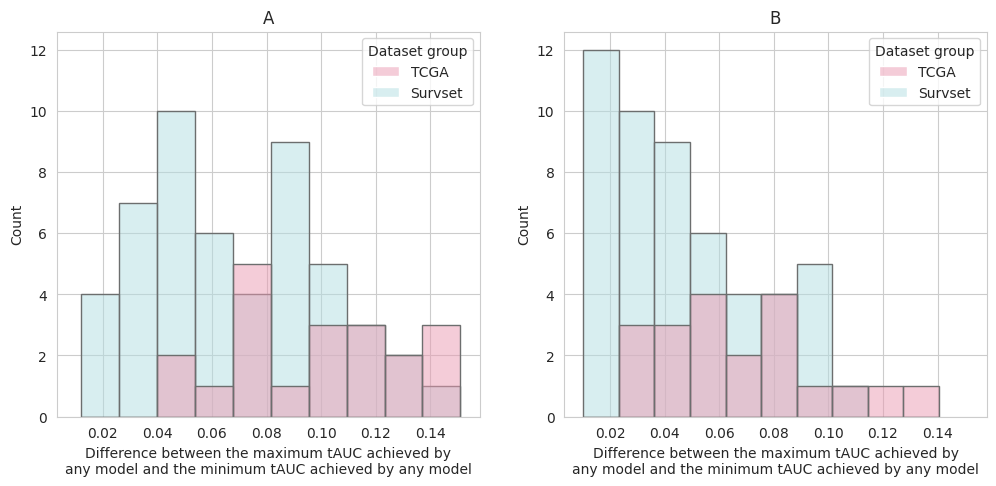

In [52]:
md = tb.drop(columns=['DecisionTree']).max(axis=1)-tb.drop(columns=['DecisionTree']).min(axis=1)
mda = tb.max(axis=1)-tb.min(axis=1)
md = pd.DataFrame(md)
mda = pd.DataFrame(mda)
md['Dataset group'] = ['TCGA' if 'TCGA' in x else 'Survset' for x in md.index]
mda['Dataset group'] = ['TCGA' if 'TCGA' in x else 'Survset' for x in mda.index]

bins=10

xlabel = 'Difference between the maximum tAUC achieved by\nany model and the minimum tAUC achieved by any model'

plt.figure(figsize=(12,5))
plt.subplot(121)
ax = sns.histplot(mda, x=0, bins=bins, hue='Dataset group', palette=palette[::-1])
import matplotlib.patches
children = ax.get_children()
for child in children:
    if isinstance(child, matplotlib.patches.Rectangle):
        # match edgecolors to facecolors
        clr = child.get_facecolor()
        child.set_edgecolor('#6c6e6e')
plt.xlabel(xlabel)
plt.title('A')
plt.subplot(122, sharex=ax, sharey=ax)
ax = sns.histplot(md, x=0, bins=bins, hue='Dataset group', palette=palette[::-1])
import matplotlib.patches
children = ax.get_children()
for child in children:
    if isinstance(child, matplotlib.patches.Rectangle):
        # match edgecolors to facecolors
        clr = child.get_facecolor()
        child.set_edgecolor('#6c6e6e')
plt.xlabel(xlabel)
plt.title('B')

missing_proportion


/tmp/ipykernel_10681/1900962515.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_t.set_xticklabels(['     *'  if 'TCGA' in x else ' ' for x in order_dt])
/tmp/ipykernel_10681/1900962515.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.ticker.NullLocator'>
  ax_t.locator_params(nbins=len(order_dt))


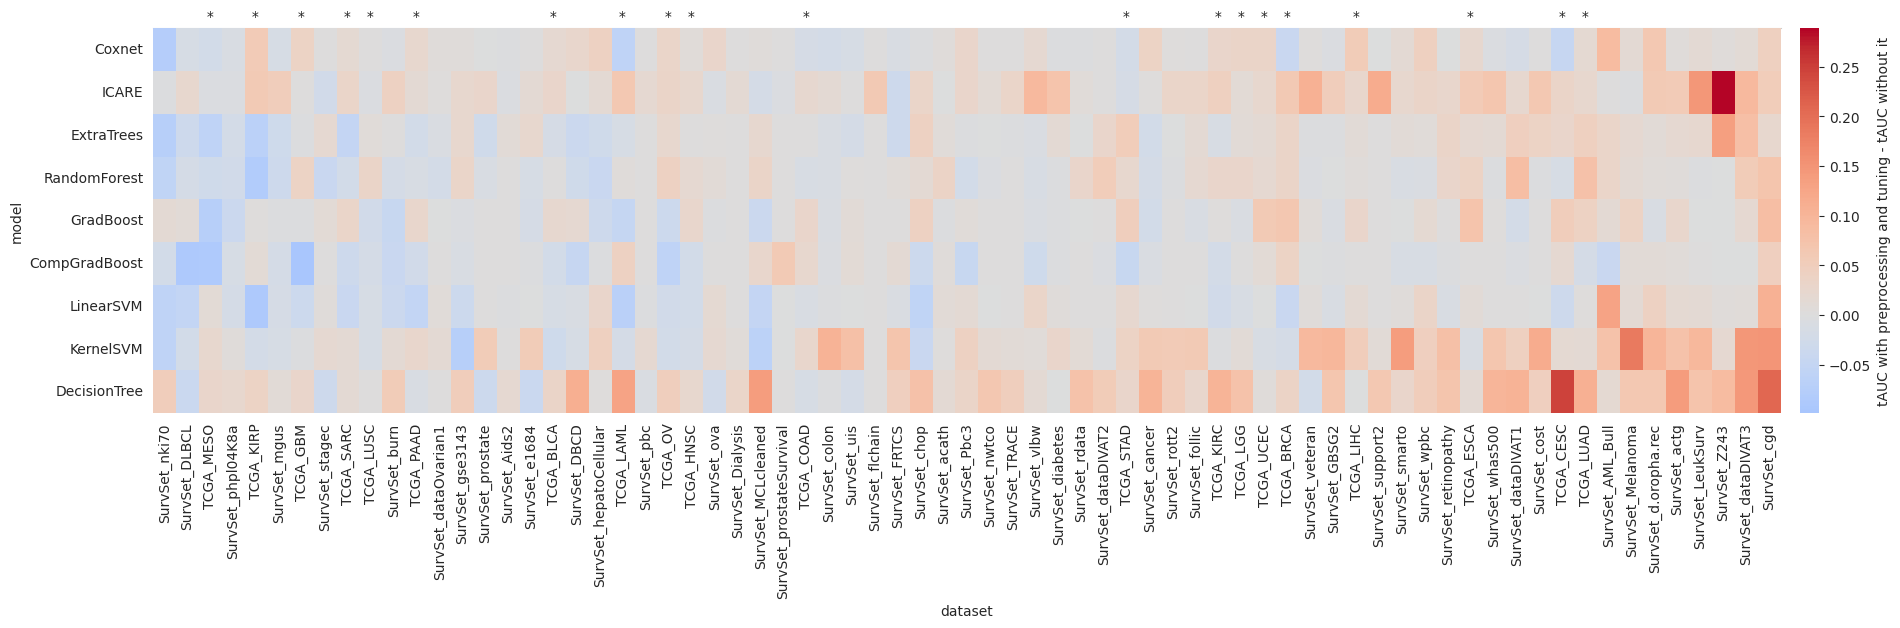

In [53]:

tb = diff_prepro.pivot_table(values='prepro - noprepro', index='model', columns='dataset', aggfunc='first').astype('float64').loc[sorted_models_alt].T
order_dt = diff_prepro.groupby('dataset')['prepro - noprepro'].mean().sort_values().index
tb = tb.loc[order_dt]

print(c)
plt.figure(figsize=(25,5))
ax = sns.heatmap(tb.T, cmap='coolwarm', cbar_kws={'label': 'tAUC with preprocessing and tuning - tAUC without it', 'pad': 0.01}, center=0)
ax_t = ax.secondary_xaxis('top')
ax_t.set_xticklabels(['     *'  if 'TCGA' in x else ' ' for x in order_dt])
ax_t.locator_params(nbins=len(order_dt))
ax_t.tick_params(length=0)

In [54]:
mean_score_by_model['ICARE_score'] = mean_score_by_model[mean_score_by_model['model']=='ICARE'].set_index('dataset').loc[mean_score_by_model['dataset'], 'tAUC'].values

In [55]:
mean_score_by_model['diff_with_ICARE'] = mean_score_by_model['ICARE_score'] - mean_score_by_model['tAUC']

In [56]:
from cmcrameri import cm

missing_proportion


/tmp/ipykernel_10681/3098190231.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_t.set_xticklabels(['      *'  if 'TCGA' in x else ' ' for x in order_dt])
/tmp/ipykernel_10681/3098190231.py:12: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.ticker.NullLocator'>
  ax_t.locator_params(nbins=len(order_dt))


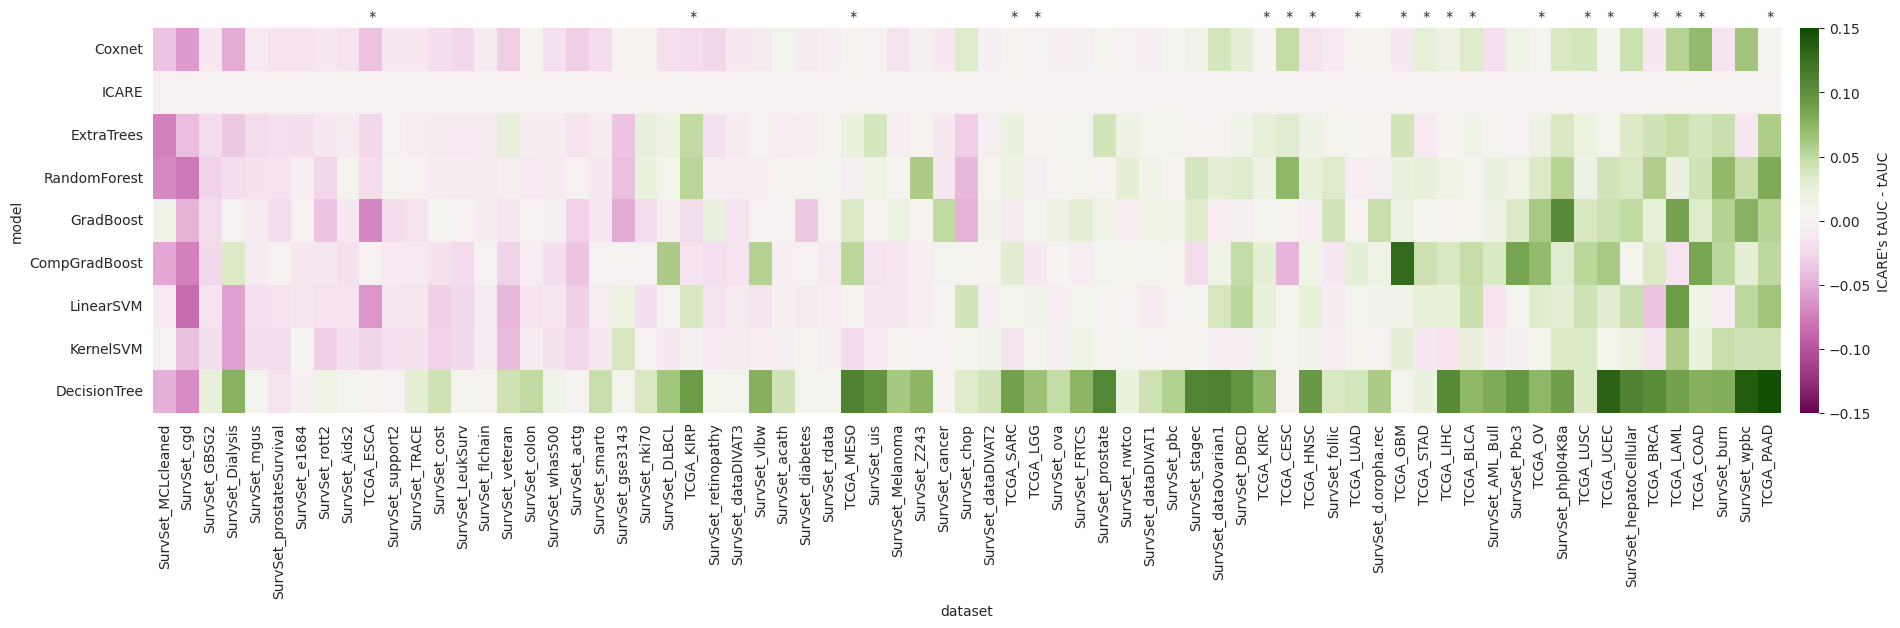

In [58]:

tb = mean_score_by_model.pivot_table(values='diff_with_ICARE', index='model', columns='dataset', aggfunc='first').astype('float64').loc[sorted_models_alt].T
order_dt = mean_score_by_model.groupby('dataset')['diff_with_ICARE'].median().sort_values().index
tb = tb.loc[order_dt]

max_abs = 0.15 #tb.abs().max().max()

print(c)
plt.figure(figsize=(25,5))
ax = sns.heatmap(tb.T, cmap=cm.bam, center=0, cbar_kws={'label': 'ICARE\'s tAUC - tAUC', 'pad': 0.01}, vmin=-max_abs, vmax=max_abs)
ax_t = ax.secondary_xaxis('top')
ax_t.set_xticklabels(['      *'  if 'TCGA' in x else ' ' for x in order_dt])
ax_t.locator_params(nbins=len(order_dt))
ax_t.tick_params(length=0)

In [59]:
tb.min().min()

-0.08505686349619834

In [60]:
tb.max().max()

0.1466066118649595

In [61]:
np.percentile(tb.values.ravel(), 50)

0.0002098564838128869

In [62]:
np.percentile(tb.values.ravel(), 5)

-0.03303199456921808

In [63]:
np.percentile(tb.values.ravel(), 1)

-0.0658088069979501

In [64]:
(tb.values.ravel() > 0).mean()

0.5007824726134585

In [65]:
(tb.values.ravel() > -0.01).mean()

0.755868544600939

In [66]:
(tb > 0.01).mean().mean()

0.3599374021909233

In [67]:
(tb > 0.025).mean().mean()

0.2410015649452269

In [68]:
(tb > 0.05).mean().mean()

0.10485133020344288

In [69]:
(tb > 0.1).mean().mean()

0.018779342723004695

In [70]:
np.percentile(tb.values, 90)

0.05119123430219289

In [71]:
mean_score_by_model

,dataset,model,tAUC,tAUC_train,datatype,core_model,prepro,best_model_score,best_model_score - score,test-train,train-test,dataset_id,ICARE_score,diff_with_ICARE
0,SurvSet_AML_Bull,CompGradBoost,0.619643,0.797536,SurvSet,CompGradBoost,True,0.674421,0.054778,-0.177893,0.177893,0,0.655299,0.035656
1,SurvSet_AML_Bull,CompGradBoost_noprepro,0.661572,0.893129,SurvSet,CompGradBoost,False,0.674421,0.012849,-0.231557,0.231557,0,0.655299,-0.006273
2,SurvSet_AML_Bull,Coxnet,0.674421,0.834967,SurvSet,Coxnet,True,0.674421,0.000000,-0.160546,0.160546,0,0.655299,-0.019122
3,SurvSet_AML_Bull,Coxnet_noprepro,0.586829,1.0,SurvSet,Coxnet,False,0.674421,0.087592,-0.413171,0.413171,0,0.655299,0.06847
4,SurvSet_AML_Bull,DecisionTree,0.573918,0.700151,SurvSet,DecisionTree,True,0.674421,0.100503,-0.126233,0.126233,0,0.655299,0.081381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,TCGA_UCEC,KernelSVM_noprepro,0.676392,0.999999,TCGA,KernelSVM,False,0.676630,0.000238,-0.323607,0.323607,70,0.67663,0.000238
1274,TCGA_UCEC,LinearSVM,0.646312,0.901122,TCGA,LinearSVM,True,0.676630,0.030318,-0.254809,0.254809,70,0.67663,0.030318
1275,TCGA_UCEC,LinearSVM_noprepro,0.647878,1.0,TCGA,LinearSVM,False,0.676630,0.028751,-0.352122,0.352122,70,0.67663,0.028751
1276,TCGA_UCEC,RandomForest,0.636772,0.848253,TCGA,RandomForest,True,0.676630,0.039857,-0.211481,0.211481,70,0.67663,0.039857


In [72]:
(mean_score_by_model['best_model_score - score'] < 0.05).mean()

0.7480438184663537

In [73]:
(mean_score_by_model['best_model_score - score'] < 0.01).mean()

0.30359937402190923

In [74]:
sdf = mean_score_by_model[(mean_score_by_model['core_model']!='DecisionTree')&(mean_score_by_model['prepro']==True)]
sdf = sdf[sdf['best_model_score - score']!=0]

In [75]:
(sdf['best_model_score - score'] < 0.032).mean()

0.6800804828973843

In [76]:
(sdf['best_model_score - score'] < 0.05).mean()

0.8430583501006036

In [77]:
(sdf['best_model_score - score'] < 0.1).mean()

0.9899396378269618

In [78]:
sdf = mean_score_by_model[(mean_score_by_model['core_model']!='DecisionTree')&(mean_score_by_model['prepro']==True)]
sdf.groupby('dataset')[['best_model_score', 'tAUC']].median().diff(axis=1)['tAUC'].quantile(0.5)

-0.01679706472400455

In [79]:
sdf[sdf['best_model_score - score']!=0].groupby('dataset')[['best_model_score', 'tAUC']].median().diff(axis=1)['tAUC'].quantile(0.5)

-0.020629168822958843

In [80]:
sdf[sdf['best_model_score - score']!=0].groupby('dataset')[['best_model_score', 'tAUC']].median().diff(axis=1)['tAUC'].quantile(0.05)

-0.060537097492587955

In [81]:
sdf[sdf['best_model_score - score']!=0].groupby('dataset')[['best_model_score', 'tAUC']].min().diff(axis=1)['tAUC'].quantile(0.3)

-0.06792096564211503

In [82]:
sdf = mean_score_by_model[(mean_score_by_model['core_model']!='DecisionTree')&(mean_score_by_model['prepro']==True)]
sdf.groupby('dataset')[['best_model_score', 'tAUC']].min().diff(axis=1)['tAUC'].quantile(0.5)

-0.04752921240318697

In [83]:
sdf.groupby('dataset')[['best_model_score', 'tAUC']].min()

,best_model_score,tAUC
dataset,,
SurvSet_AML_Bull,0.674421,0.619643
SurvSet_Aids2,0.584194,0.553767
SurvSet_DBCD,0.785601,0.72818
SurvSet_DLBCL,0.651348,0.571708
SurvSet_Dialysis,0.789146,0.697278
...,...,...
TCGA_OV,0.632210,0.561877
TCGA_PAAD,0.665698,0.583874
TCGA_SARC,0.710461,0.663781


In [84]:
# sdf = mean_score_by_model[(mean_score_by_model['core_model']!='DecisionTree')&(mean_score_by_model['prepro']==True)]
sdf = mean_score_by_model[(mean_score_by_model['prepro']==True)]
sdf = sdf[sdf['best_model_score - score']!=0]
(sdf.groupby('dataset')[['best_model_score', 'tAUC']].median().diff(axis=1)['tAUC'] < -0.1).sum()

0

In [85]:
sdf.groupby('dataset')[['best_model_score', 'tAUC']].median().diff(axis=1)['tAUC'].quantile(0.5)

-0.022046618784919758

In [86]:
sdf.groupby('dataset')[['best_model_score', 'tAUC']].median().diff(axis=1)['tAUC'].quantile(0.05)

-0.05868253532369472

In [87]:
sdf

,dataset,model,tAUC,tAUC_train,datatype,core_model,prepro,best_model_score,best_model_score - score,test-train,train-test,dataset_id,ICARE_score,diff_with_ICARE
0,SurvSet_AML_Bull,CompGradBoost,0.619643,0.797536,SurvSet,CompGradBoost,True,0.674421,0.054778,-0.177893,0.177893,0,0.655299,0.035656
4,SurvSet_AML_Bull,DecisionTree,0.573918,0.700151,SurvSet,DecisionTree,True,0.674421,0.100503,-0.126233,0.126233,0,0.655299,0.081381
6,SurvSet_AML_Bull,ExtraTrees,0.649946,0.854299,SurvSet,ExtraTrees,True,0.674421,0.024475,-0.204354,0.204354,0,0.655299,0.005354
8,SurvSet_AML_Bull,GradBoost,0.637373,0.928981,SurvSet,GradBoost,True,0.674421,0.037048,-0.291608,0.291608,0,0.655299,0.017926
10,SurvSet_AML_Bull,ICARE,0.655299,0.840088,SurvSet,ICARE,True,0.674421,0.019122,-0.184788,0.184788,0,0.655299,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,TCGA_UCEC,ExtraTrees,0.664824,0.810655,TCGA,ExtraTrees,True,0.676630,0.011806,-0.145831,0.145831,70,0.67663,0.011806
1268,TCGA_UCEC,GradBoost,0.632353,0.920564,TCGA,GradBoost,True,0.676630,0.044277,-0.28821,0.28821,70,0.67663,0.044277
1272,TCGA_UCEC,KernelSVM,0.665071,0.880816,TCGA,KernelSVM,True,0.676630,0.011559,-0.215745,0.215745,70,0.67663,0.011559
1274,TCGA_UCEC,LinearSVM,0.646312,0.901122,TCGA,LinearSVM,True,0.676630,0.030318,-0.254809,0.254809,70,0.67663,0.030318


In [88]:
sdf = mean_score_by_model[(mean_score_by_model['prepro']==True)]
sdf['tmp'] = sdf['test-train'] > -0.2
sdf.groupby(['datatype', 'model'])['tmp'].mean()

/tmp/ipykernel_10681/386341448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['tmp'] = sdf['test-train'] > -0.2


datatype  model        
SurvSet   CompGradBoost    0.980392
          Coxnet           0.921569
          DecisionTree     1.000000
          ExtraTrees       0.941176
          GradBoost        0.803922
          ICARE            0.960784
          KernelSVM        0.882353
          LinearSVM        0.921569
          RandomForest     0.862745
TCGA      CompGradBoost    0.850000
          Coxnet           0.450000
          DecisionTree     0.850000
          ExtraTrees       0.700000
          GradBoost        0.200000
          ICARE            0.800000
          KernelSVM        0.300000
          LinearSVM        0.250000
          RandomForest     0.450000
Name: tmp, dtype: float64

In [89]:
sdf = mean_score_by_model[(mean_score_by_model['prepro']==True)]
sdf = sdf[sdf['core_model']=='ICARE']
(sdf['best_model_score - score']<0.03).mean()

0.8169014084507042

In [90]:
(sdf['best_model_score - score']).quantile(0.5)

0.015868372616338777

In [91]:
(sdf['best_model_score - score']).quantile(0.95)

0.05424363406212396

In [92]:
mean_score_by_model['test-train']

0      -0.177893
1      -0.231557
2      -0.160546
3      -0.413171
4      -0.126233
          ...   
1273   -0.323607
1274   -0.254809
1275   -0.352122
1276   -0.211481
1277   -0.374514
Name: test-train, Length: 1278, dtype: object

In [93]:
tb = diff_prepro.pivot_table(values='prepro - noprepro', index='model', columns='dataset', aggfunc='first').astype('float64').loc[sorted_models_alt].T
order_dt = diff_prepro.groupby('dataset')['prepro - noprepro'].mean().sort_values().index
tb = tb.loc[order_dt]


In [94]:
tb

model,Coxnet,ICARE,ExtraTrees,RandomForest,GradBoost,CompGradBoost,LinearSVM,KernelSVM,DecisionTree
dataset,,,,,,,,,
SurvSet_nki70,-0.076870,-0.003705,-0.073079,-0.057463,0.015430,-0.021511,-0.059264,-0.058035,0.050776
SurvSet_DLBCL,-0.014910,0.022795,-0.032035,-0.019885,0.009057,-0.086973,-0.052056,-0.023940,-0.038511
TCGA_MESO,-0.023974,-0.005734,-0.060139,-0.028401,-0.073241,-0.086348,0.012481,0.025304,0.028357
SurvSet_phpl04K8a,-0.010224,-0.005516,-0.020531,-0.025211,-0.035876,-0.014129,-0.017644,0.004278,0.023682
TCGA_KIRP,0.057679,0.061251,-0.065399,-0.081232,0.003441,0.011933,-0.087068,-0.020216,0.038881
...,...,...,...,...,...,...,...,...,...
SurvSet_actg,0.006342,0.057981,0.019284,0.005618,0.026345,0.008428,0.017845,0.074198,0.141319
SurvSet_LeukSurv,0.014498,0.146801,0.021551,-0.002493,-0.001730,0.000000,0.015753,0.096325,0.073757
SurvSet_Z243,0.005812,0.288698,0.136734,-0.001135,-0.001755,-0.001006,0.006820,0.020677,0.089885


Text(0.5, 0, 'Gain in tAUC through model tuning and feature selection')

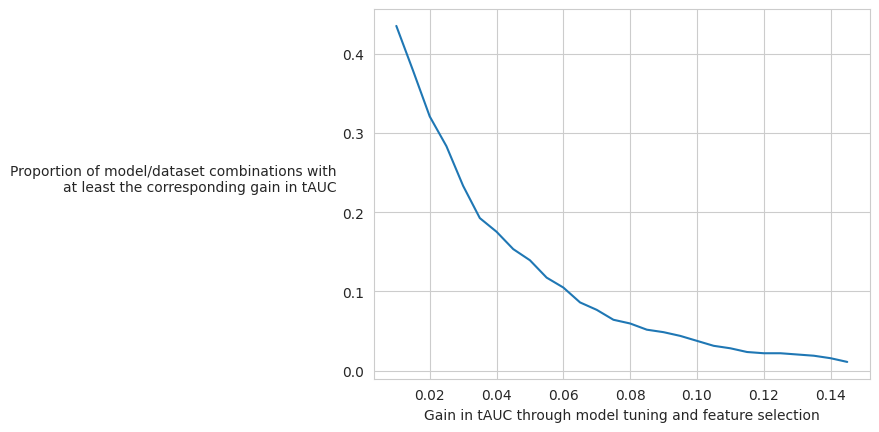

In [95]:
xs = np.arange(0.01, 0.15, 0.005)
y = []
for x in xs:
    y.append((tb > x).mean().mean())
plt.plot(xs, y)
plt.ylabel('Proportion of model/dataset combinations with\nat least the corresponding gain in tAUC')
plt.gca().yaxis.label.set(rotation='horizontal', ha='right');
plt.xlabel('Gain in tAUC through model tuning and feature selection')

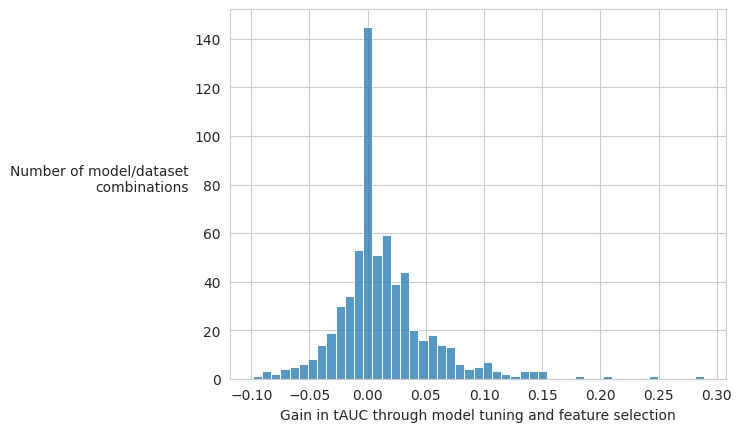

In [96]:
sns.histplot(tb.values.ravel())
plt.xlabel('Gain in tAUC through model tuning and feature selection')
plt.ylabel('Number of model/dataset\ncombinations')
plt.gca().yaxis.label.set(rotation='horizontal', ha='right');


In [97]:
np.mean(tb.values.ravel())

0.013040631806449416

In [98]:
np.median(tb.values.ravel())

0.00373408724848745